/tmp/ipykernel_22212/3845584648.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(game_scores_by_exp, labels=labels)


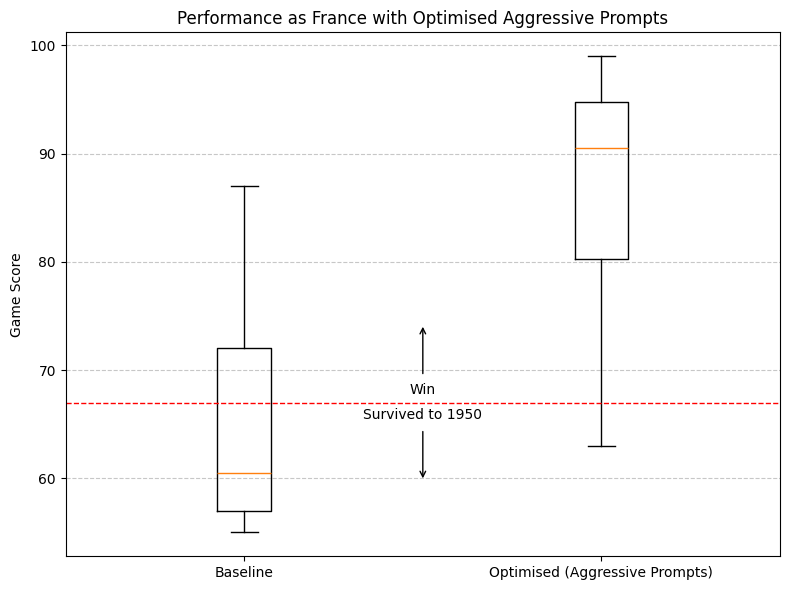

/tmp/ipykernel_22212/3845584648.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(sc_counts_by_exp, labels=labels)


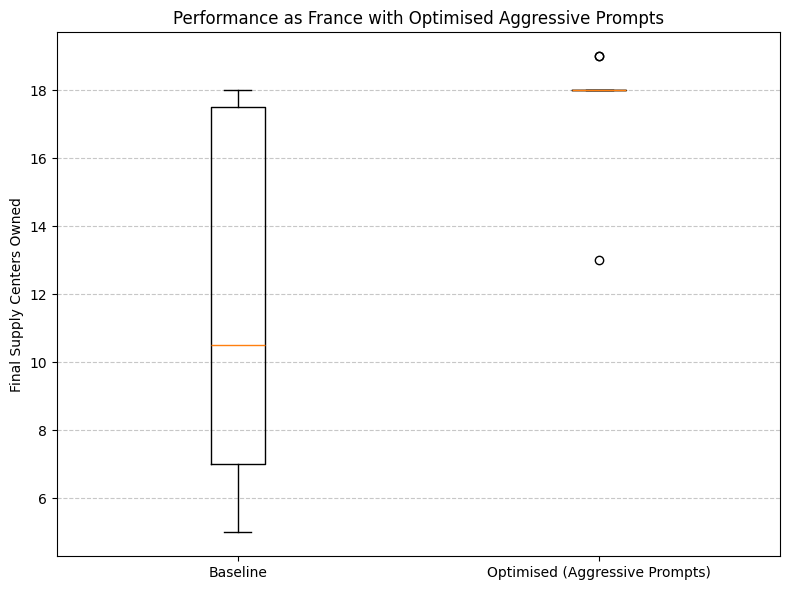

Final Supply Center Counts for France:
----------------------------------------
Baseline:
[10, 7, 6, 7, 16, 18, 5, 18, 18, 11]
  (N=10, Mean=11.60, Median=10.50)
----------------------------------------
Optimised (Aggressive Prompts):
[19, 18, 18, 19, 13, 18, 18, 18, 18, 18]
  (N=10, Mean=17.70, Median=18.00)
----------------------------------------


In [6]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# EDIT THE LIST BELOW: absolute or relative paths to your experiment folders
# Each folder should contain analysis/statistical_game_analysis/individual/*
# ---------------------------------------------------------------------------
exp_dirs = {
    "../data/sam-exp103": "Baseline",
    "../data/sam-exp104": "Optimised (Aggressive Prompts)",
}

# ---------------------------------------------------------------------------
# Collect France game_score and final_supply_centers_owned for each experiment
# ---------------------------------------------------------------------------
records = []
for exp_dir, label in exp_dirs.items():
    exp_path = Path(exp_dir).expanduser().resolve()
    csv_dir = exp_path / "analysis" / "statistical_game_analysis" / "individual"

    if not csv_dir.exists():
        print(f"warning: Directory not found, skipping: {csv_dir}")
        continue

    csv_files = sorted(csv_dir.glob("run_*_game_analysis.csv"))

    if not csv_files:
        print(f"warning: No CSV files found in {csv_dir}")
        continue

    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            france_rows = df[df["power_name"] == "FRANCE"]
            if not france_rows.empty and {
                "game_score",
                "final_supply_centers_owned",
            }.issubset(france_rows.columns):
                records.append(
                    {
                        "Experiment": label,
                        "game_score": float(france_rows.iloc[0]["game_score"]),
                        "final_sc_count": int(france_rows.iloc[0]["final_supply_centers_owned"]),
                    }
                )
        except Exception as exc:
            print(f"warning: Could not process {csv_file} – {exc}")

# ---------------------------------------------------------------------------
# Build summary DataFrame
# ---------------------------------------------------------------------------
if not records:
    raise RuntimeError("No data collected – check the paths and directory structure.")

data_df = pd.DataFrame(records)

labels = list(exp_dirs.values())
game_scores_by_exp = [
    data_df[data_df["Experiment"] == label]["game_score"] for label in labels
]
sc_counts_by_exp = [
    data_df[data_df["Experiment"] == label]["final_sc_count"] for label in labels
]

# ---------------------------------------------------------------------------
# Plot 1: Box plot for Game Score (with threshold + annotations)
# ---------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
ax1 = plt.gca()  # grab the current axes so we can annotate later

ax1.boxplot(game_scores_by_exp, labels=labels)
ax1.set_title("Performance as France with Optimised Aggressive Prompts")
ax1.set_ylabel("Game Score")
ax1.grid(axis="y", linestyle="--", alpha=0.7)

# ---- reference line + arrows (labels closer to the line) -------------------
threshold = 67
ax1.axhline(threshold, linestyle="--", linewidth=1, color="red")

y_span = ax1.get_ylim()[1] - ax1.get_ylim()[0]

# keep the arrow geometry you liked
arrow_head_offset = 0.15 * y_span   # distance of arrow HEAD from the line
arrow_tail_offset = 0.05 * y_span   # distance of arrow TAIL from the line

# new, much smaller gap for the text itself
text_offset       = 0.01 * y_span   # distance of label from the line

x_midpoint = (1 + len(labels)) / 2

# ↑  Win
arrow_tail_top = threshold + arrow_tail_offset
arrow_head_top = threshold + arrow_head_offset
ax1.annotate(
    '', xy=(x_midpoint, arrow_head_top),
    xytext=(x_midpoint, arrow_tail_top),
    arrowprops=dict(arrowstyle='->', linewidth=1)
)
ax1.text(
    x_midpoint, threshold + text_offset,
    'Win',
    ha='center', va='bottom'
)

# Survived to 1950  ↓
arrow_tail_bottom = threshold - arrow_tail_offset
arrow_head_bottom = threshold - arrow_head_offset
ax1.annotate(
    '', xy=(x_midpoint, arrow_head_bottom),
    xytext=(x_midpoint, arrow_tail_bottom),
    arrowprops=dict(arrowstyle='->', linewidth=1)
)
ax1.text(
    x_midpoint, threshold - text_offset,
    'Survived to 1950',
    ha='center', va='top'
)
# ---------------------------------------------------------------------------

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Plot 2: Box plot for Final Supply Centers Owned
# ---------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
ax2 = plt.gca()

ax2.boxplot(sc_counts_by_exp, labels=labels)
ax2.set_title("Performance as France with Optimised Aggressive Prompts")
ax2.set_ylabel("Final Supply Centers Owned")
ax2.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# Print the final supply center counts for all games
# ---------------------------------------------------------------------------
print("Final Supply Center Counts for France:")
print("-" * 40)
for label, sc_series in zip(labels, sc_counts_by_exp):
    sc_list = sc_series.tolist()
    print(f"{label}:")
    print(sc_list)
    print(f"  (N={len(sc_list)}, Mean={np.mean(sc_list):.2f}, Median={np.median(sc_list):.2f})")
    print("-" * 40)
